##### To build a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost, follow these steps: First, load and clean your data to ensure it is accurate and relevant. Next, select key features and split the dataset into training and testing sets. Normalize the features through scaling to ensure they are equally weighted. Use a sparse autoencoder to reduce the dimensionality of the data, facilitating more efficient processing. Apply an Isolation Forest to initially identify and isolate potential anomalies. Further refine this detection with XGBoost, enhancing the model's accuracy, especially for subtle anomalies. Finally, evaluate the model using precision, recall, F1-score, and a confusion matrix to assess its overall performance and accuracy. This sequential approach leverages each method's strengths to create a robust and effective anomaly detection system.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

Epoch 1/50
138/138 [==============================] - 1s 2ms/step - loss: 0.0702 - val_loss: 0.0413
Epoch 2/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0281
Epoch 3/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0196
Epoch 4/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 5/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0109
Epoch 6/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 7/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 8/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 9/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0039

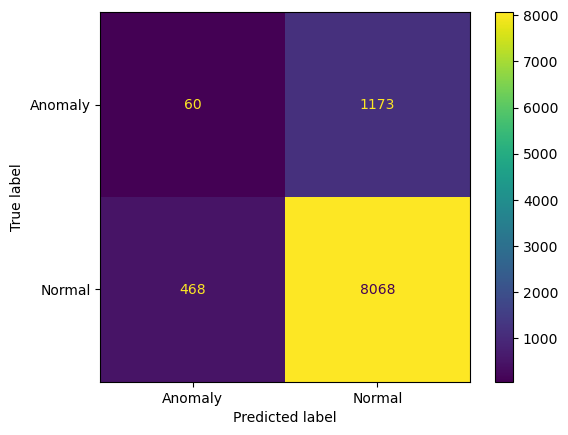

In [3]:

def hybrid_anomaly_detection():
    # Load data from a CSV file
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()


    data.dropna(axis=0, inplace=True)

    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Define and train the autoencoder
    input_dim = X_scaled.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    # Filter data where Isolation Forest predicts normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train XGBoost on the filtered normal data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset with XGBoost
    xgb_predictions = xgb.predict(X_test_encoded)
    
    # Evaluate the model
    precision = precision_score(y_test, xgb_predictions, pos_label=1)
    recall = recall_score(y_test, xgb_predictions, pos_label=1)
    f1 = f1_score(y_test, xgb_predictions, pos_label=1)
    
    
    print(classification_report(y_test, xgb_predictions))
    
    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, xgb_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
hybrid_anomaly_detection()


Epoch 1/50
56/56 [==============================] - 1s 3ms/step - loss: 0.0412 - val_loss: 0.0317
Epoch 2/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0212
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0146
Epoch 4/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0114
Epoch 5/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 8/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 9/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 10/50
56/56 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 11/50
56/56 [

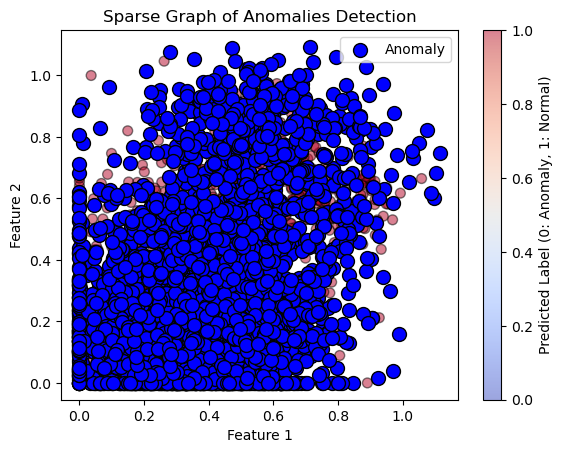

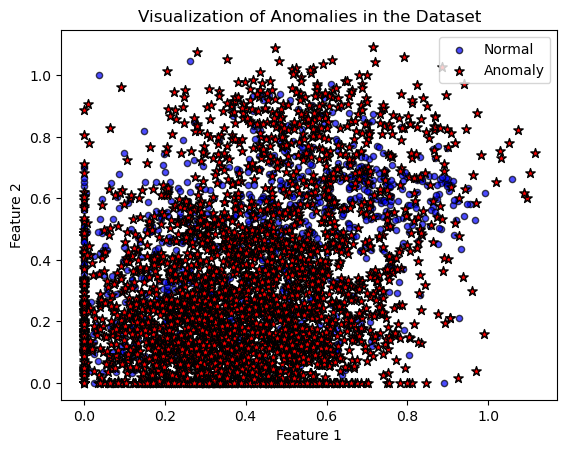

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def complete_anomaly_detection_system():
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 5, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_normal, y_train_normal)
    
    xgb_predictions = xgb.predict(X_test_encoded)
    
    # Plotting the results
    plot_sparse_graph(X_test_encoded, y_test, xgb_predictions)

def plot_sparse_graph(X, y, predictions):
    fig, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], X[:, 1], c=predictions, cmap='coolwarm', edgecolor='k', s=50, alpha=0.5)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Predicted Label (0: Anomaly, 1: Normal)')
    
    anomalies = X[predictions == 0]
    ax.scatter(anomalies[:, 0], anomalies[:, 1], color='blue', label='Anomaly', edgecolor='k', s=100)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Sparse Graph of Anomalies Detection')
    ax.legend()
    
    plt.show()
    
    
    fig, ax = plt.subplots()
    # Plot normal points with a default color
    normal = X[predictions == 1]  # Assuming '1' is the label for normal
    anomalies = X[predictions == 0]  # Assuming '0' is the label for anomalies

    # Scatter plot for normal points
    ax.scatter(normal[:, 0], normal[:, 1], c='blue', label='Normal', edgecolor='k', s=20, alpha=0.7)

    # Scatter plot for anomalies
    ax.scatter(anomalies[:, 0], anomalies[:, 1], c='red', label='Anomaly', edgecolor='black', s=50, marker='*')

    # Additional plot settings
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Visualization of Anomalies in the Dataset')
    ax.legend(loc='upper right')
    
    plt.show()
    
    
    

# Example usage
complete_anomaly_detection_system()
